## Analyzing Paper Citation Statistics
This notebook shows how to load and analyze the raw data. It studies some basic statistics: the total number of accepted papers and the papers we found citation information for, the distribution of paper citations in a conference, the popularity of a topic over time, and (noisy) academia/industry splits. For more details on all of these, check out the [blogpost](http://maithraraghu.com/blog/2019/Citation_Statistics_of_Machine_Learning_Papers/)!

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from copy import deepcopy
from matplotlib import cm
from IPython.display import display, HTML

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 80)

### Load the Data

In [3]:
# We have data for ICML from 2017 and 2018, and from NeurIPS from 2014, 2015, 2016, 2017, 2018
icmls = []
icml_years = ["2017", "2018"]

for iy in icml_years:
    with open("./results_ICML_%s.p"%iy, "rb") as f:
        icmls.append(pickle.load(f))
        
neurips = []
neurips_years = ["2014", "2015", "2016", "2017", "2018"]

for ny in neurips_years:
    with open("./results_NeurIPS_%s.p"%ny, "rb") as f:
        neurips.append(pickle.load(f))

### Total Number of Accepted Papers, Total Number with Citation Information Found

ICML 2017: total accepted papers 434, papers with citation data 398
ICML 2018: total accepted papers 621, papers with citation data 555
NeurIPS 2014: total accepted papers 411, papers with citation data 363
NeurIPS 2015: total accepted papers 403, papers with citation data 365
NeurIPS 2016: total accepted papers 568, papers with citation data 500
NeurIPS 2017: total accepted papers 679, papers with citation data 635
NeurIPS 2018: total accepted papers 1009, papers with citation data 943


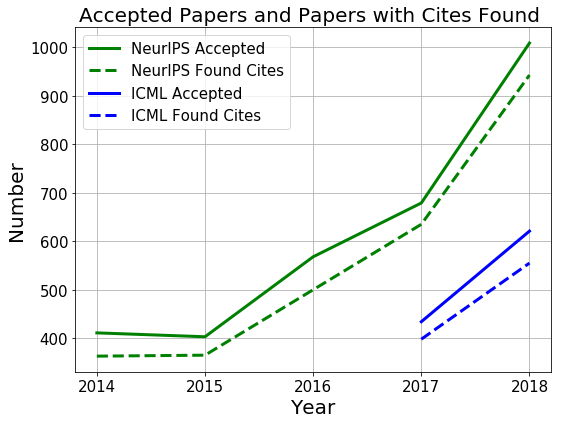

In [4]:
# Let's look at the total number of accepted papers, and how many we successfully found citations for
iaccepted = []
icited = []
naccepted = []
ncited = []

for i, iy in enumerate(icml_years):
    iaccepted.append(icmls[i].shape[0])
    icited.append(np.sum(~icmls[i].citations.isna()))
    print('ICML %s: total accepted papers %d, papers with citation data %d'%(iy,
                                                                             iaccepted[-1],
                                                                             icited[-1]))
                                                                             

for i, ny in enumerate(neurips_years):
    naccepted.append(neurips[i].shape[0])
    ncited.append(np.sum(~neurips[i].citations.isna()))
    print('NeurIPS %s: total accepted papers %d, papers with citation data %d'%(ny,
                                                                                naccepted[-1],
                                                                                ncited[-1]))
    
# make a plot
plt.figure(figsize=(8,6))
plt.title("Accepted Papers and Papers with Cites Found ", fontsize=20)
plt.plot([int(n) for n in neurips_years], 
         naccepted, lw=3.0, c='green', label='NeurIPS Accepted')
plt.plot([int(n) for n in neurips_years], 
         ncited, lw=3.0, c='green', label='NeurIPS Found Cites', linestyle='--')
plt.plot([int(i) for i in icml_years], 
         iaccepted, lw=3.0, c='blue', label='ICML Accepted')
plt.plot([int(i) for i in icml_years], 
         icited, lw=3.0, c='blue', label='ICML Found Cites', linestyle='--')

plt.grid()
plt.legend(loc="best", fontsize=15)
plt.xticks([2014, 2015, 2016, 2017, 2018], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number', fontsize=20)
plt.tight_layout()

### Top 10 Most Cited Papers in NeurIPS 2014, 2015, 2016
Let's take a look at the top 10 most cited papers (according to our scraper, run on March 31st 2019) from NeurIPS in 2014, 2015 and 2016 

In [5]:
most_cited = []
for n, ny in enumerate(neurips_years[:3]):
    df = neurips[n]
    sorted_df = df.sort_values("citations", ascending=False)
    print('NeurIPS %s'%ny)
    display(HTML(sorted_df[['name', 'citations']].head(n=10).to_html(index=False)))
    

NeurIPS 2014


name,citations
Generative Adversarial Nets,7990
Sequence to Sequence Learning with Neural Networks,6098
Two-Stream Convolutional Networks for Action Recognition in Videos,2397
How transferable are features in deep neural networks?,2302
Learning Deep Features for Scene Recognition using Places Database,1724
Recurrent Models of Visual Attention,996
Semi-supervised Learning with Deep Generative Models,865
Neural Word Embedding as Implicit Matrix Factorization,854
Depth Map Prediction from a Single Image using a Multi-Scale Deep Network,848
Joint Training of a Convolutional Network and a Graphical Model for Human Po...,700


NeurIPS 2015


name,citations
Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks,8601
Spatial Transformer Networks,1452
Learning both Weights and Connections for Efficient Neural Network,1125
Character-level Convolutional Networks for Text Classification,1073
Skip-Thought Vectors,958
Deep Generative Image Models using a ￼Laplacian Pyramid of Adversarial Networks,930
Teaching Machines to Read and Comprehend,807
BinaryConnect: Training Deep Neural Networks with binary weights during prop...,753
Convolutional LSTM Network: A Machine Learning Approach for Precipitation No...,736
Training Very Deep Networks,610


NeurIPS 2016


name,citations
Improved Techniques for Training GANs,1649
R-FCN: Object Detection via Region-based Fully Convolutional Networks,1142
InfoGAN: Interpretable Representation Learning by Information Maximizing Gen...,930
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering,654
Matching Networks for One Shot Learning,544
A Theoretically Grounded Application of Dropout in Recurrent Neural Networks,510
Conditional Image Generation with PixelCNN Decoders,486
Coupled Generative Adversarial Networks,422
Learning Structured Sparsity in Deep Neural Networks,418
Learning a Probabilistic Latent Space of Object Shapes via 3D Generative-Adv...,410


#### Some Observations
* **2014** Some very impactful papers in generative models made an appearance, as did recurrent models and attention.
* **2015** Significant results in object detection and compression, as well as further insights into generative models, language modelling and recurrent networks
* **2016** Lots of generative models, also CNNs on graphs and few shot learning

### Top Cited NeurIPS papers of 2017, 2018
There are a couple missing from the top cited list here (e.g. [World Models](https://arxiv.org/abs/1803.10122) from NeurIPS 2018, which has a slightly different name in the conference proceedings vs the Google Scholar entry), but the list is still useful to get an idea of things.

In [6]:
most_cited = []
for n, ny in enumerate(neurips_years[3:]):
    df = neurips[n+3]
    sorted_df = df.sort_values("citations", ascending=False)
    print('NeurIPS %s'%ny)
    display(HTML(sorted_df[['name', 'citations']].head(n=10).to_html(index=False)))

NeurIPS 2017


name,citations
Attention is All you Need,1402
Improved Training of Wasserstein GANs,1107
Self-Normalizing Neural Networks,413
Unsupervised Image-to-Image Translation Networks,399
PointNet++: Deep Hierarchical Feature Learning on Point Sets in a Metric Space,365
GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equili...,324
Inductive Representation Learning on Large Graphs,307
Prototypical Networks for Few-shot Learning,298
What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?,283
A simple neural network module for relational reasoning,252


NeurIPS 2018


name,citations
Are GANs Created Equal? A Large-Scale Study,123
Visualizing the Loss Landscape of Neural Nets,89
Natasha 2: Faster Non-Convex Optimization Than SGD,72
Glow: Generative Flow with Invertible 1x1 Convolutions,67
PointCNN: Convolution On X-Transformed Points,59
Simple random search of static linear policies is competitive for reinforcem...,56
Isolating Sources of Disentanglement in Variational Autoencoders,51
How Does Batch Normalization Help Optimization?,51
Adversarially Robust Generalization Requires More Data,46
Improving Exploration in Evolution Strategies for Deep Reinforcement Learnin...,45


### Citation Distributions
We can also look at the distribution of paper citations in a particular year. Below we plot this distribution for papers from NeurIPS 2014 and NeurIPS 2017.

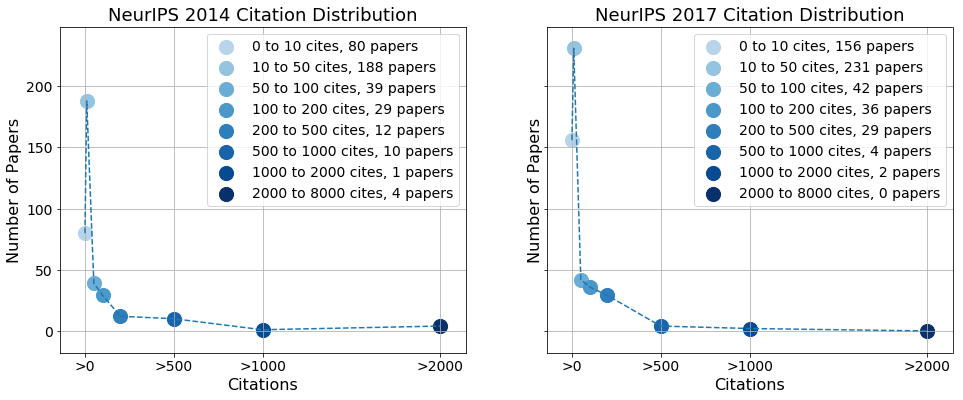

In [7]:
# Citation distributions for NeurIPS 2014 and NeurIPS 2017
raw2014 = np.asarray(neurips[0].citations[~neurips[0].citations.isna()])
raw2017 = np.asarray(neurips[2].citations[~neurips[2].citations.isna()])

bins = [0, 10, 50, 100, 200, 500, 1000, 2000, 8000]

c2014, _ = np.histogram(raw2014, bins)
c2017, _ = np.histogram(raw2017, bins)

def _plot_helper(ax, bins, data, xlabel, ylabel, title):
    ax.grid()
    colors = cm.Blues(np.linspace(0.3, 1, len(bins[:-1])))
    ax.plot(bins[:-1], data, linestyle='--')
    for i, b in enumerate(bins[:-1]):
        ax.scatter(b, data[i], s=200, color=colors[i], 
                   label='%d to %d cites, %d papers'%(bins[i], bins[i+1], data[i]))
#     ax.scatter(bins[:-1], data, s=200)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    _ = ax.set_xticks([0, 500, 1000, 2000])
    _ = ax.set_xticklabels(['>%d'%i for i in [0, 500, 1000, 2000]])
    ax.tick_params(axis='both', which='major', labelsize=14)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
_plot_helper(axs[0], bins, c2014, 
             'Citations',
            'Number of Papers',
            'NeurIPS 2014 Citation Distribution')
_plot_helper(axs[1], bins, c2017, 
             'Citations',
            'Number of Papers',
            'NeurIPS 2017 Citation Distribution')

plt.savefig('NeurIPS_Citation_Distribution.png')

#### Observations
The most frequent number of citations for papers is 10 to 50 citations across both years, with almost 250 papers from NeurIPS 2017 and 200 papers from NeurIPS 2014 having this many citations. NeurIPS 2017 has more papers in total, 635 compared to 363 for NeurIPS 2014. Perhaps unsurprisingly (given the longer amount of time for NeurIPS 2014 papers to spread), NeurIPS 2014 has more very highly cited (> 500 citations) papers than NeurIPS 2017.

### Topic Trends: GANs
The data can also be used to give some insights into popular topics, and how these change with time, by doing some analysis on the titles. Here we'll try this out for GANs, as the original GAN paper came out in NeurIPS 2014, and it's interesting to see how the frequency has spread

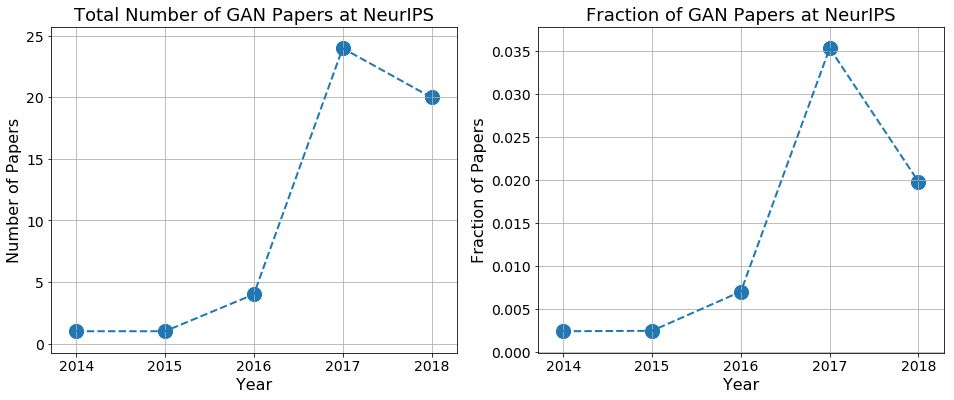

In [8]:
# rough frequency of GAN papers
gan_keywords = ['gan ',
                ' gan',
                'gans ',
                ' gans',
                'generative adversarial net',
                'generative adversarial nets',   
                'generative adversarial network',
                'generative adversarial networks',]
gan_frequencies = []
for df in neurips:
    count = 0.
    titles = list(df.name)
    # enumerate through titles to see which are GAN papers
    for t in titles:
        # preprocess to help with keyword match
        t = t.lower()
        t = re.sub('[^0-9a-zA-Z]+', ' ', t)
        
        # check if any of the keywords are in the title
        for gk in gan_keywords:
            if gk in t:
                count += 1
                break

    # add the count and the total number of paeprs
    gan_frequencies.append((count, len(df)))
    
# plot of the results
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

def _gan_plot_helper(ax, ys, xlabel, ylabel, title):
    ax.plot(neurips_years, ys, lw=2.0, linestyle='--')
    ax.scatter(neurips_years, ys, s=200)
    ax.grid()
    ax.set_title(title, fontsize=18)
    _ = ax.set_xticks([int(ny) for ny in neurips_years])
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
_gan_plot_helper(axs[0], [i[0] for i in gan_frequencies], 
                'Year', 'Number of Papers',
                'Total Number of GAN Papers at NeurIPS')

_gan_plot_helper(axs[1], [float(i[0])/i[1] for i in gan_frequencies], 
                'Year', 'Fraction of Papers',
                'Fraction of GAN Papers at NeurIPS')

plt.savefig('GAN_Trends.png')

### Compute an Approximate Split Between Academia and Industry
We can also try and determine approximate academia industry breakdown, using the affiliation data. There are several sources of noise in this computation:
1. The scraper only picks up one affiliation per paper (often the first author, but not always). This might not be an accurate representation of the paper's origin.
2. **Significant challenge:** The affiliation taken from Google Scholar is the *current* affiliation of the author, not their affiliation when they wrote the paper.
3. (more minor) Academia/Industry determination is done by a noisy keyword matching, which is not comprehensive (but should provide a reasonable sample of both.) 

The most significant source of noise is 2. We study the effect of current/former affiliations after a first attempt at determining the academia/industry split

In [9]:
academia = ["university", "technion", 'cornell', "stanford", "student",
           "professor", "massachusetts institute of technology",
           "princeton", "caltech", "college", "berkeley", "harvard",
           "Georgia Tech", "inria", "institute of technology", "mit",
           "max planck", "school", "eth zurich", "mila", "montreal", "nyu",
           "weizmann", "iit", "ku leuven", "Noah's Ark", "kaist", "epfl", "ucla",
           "ut austin", "department", "eth zurich", "cmu", "carnegie mellon", 
           'umass amherst', "université", "institute", "gatsby", 'cambridge']
industry = ["element ai", "google", "facebook",
           "microsoft", "deepmind", "adobe", "nvidia", "uber", "ai lab",
           "amazon", "yahoo", "msr", 'fast.ai', "netflix", "openai", "open ai", "apple",
           "vicarious ai", "twitter", "hhmi janelia", "bosch", "sk t-brain",
           "preferred networks", "happy elements", "clova ai research",
           "disney", '.ai']

def match_affil(raw, arr):
    # for a given raw set of affiliations (raw) and 
    # a list of affiliations (arr), sees if raw is in arr
    if pd.isna(raw):
        return raw
    affil = raw.lower().strip().replace(",", "")
    for a in arr:
        if a in affil:
            return 1
    return 0

def percentage_acad_ind(df):
    # helper to compute percentage
    # discards null values and unmatched papers
    acad = float(np.sum(df["academia"]))
    industry = float(np.sum(df["industry"]))
    total = acad + industry
    
    return industry/total, acad/total

In [10]:
# compute percentage academia industry
top = [0.05, 0.1, 0.2, 0.4, 1.]
n_all = np.zeros((len(top), len(neurips)))
i_all = np.zeros((len(top), len(icmls)))

for idx, ratio in enumerate(top):
    n_results = []
    i_results = []
    
    # results for NeurIPS
    for n in neurips:
        t = int(ratio*n.shape[0])
        tmp = deepcopy(n)
        # try to label as academia or industry with the one noisy label
        tmp["academia"] = tmp["affiliations"].apply(match_affil, args=(academia,))
        tmp["industry"] = tmp["affiliations"].apply(match_affil, args=(industry,))
        
        # compute proportions across different citation bands
        tmp_sorted = tmp.sort_values("citations", ascending=False)[:t]
        ind, acad = percentage_acad_ind(tmp_sorted)
        n_results.append(ind)
        
    # results for ICML
    for i in icmls:
        t = int(ratio*i.shape[0])
        tmp = deepcopy(i)
        tmp["academia"] = tmp["affiliations"].apply(match_affil, args=(academia,))
        tmp["industry"] = tmp["affiliations"].apply(match_affil, args=(industry,))
        tmp_sorted = tmp.sort_values("citations", ascending=False)[:t]
        ind, acad = percentage_acad_ind(tmp_sorted)
        i_results.append(ind)
    
    # add in to array
    n_all[idx] = n_results
    i_all[idx] = i_results


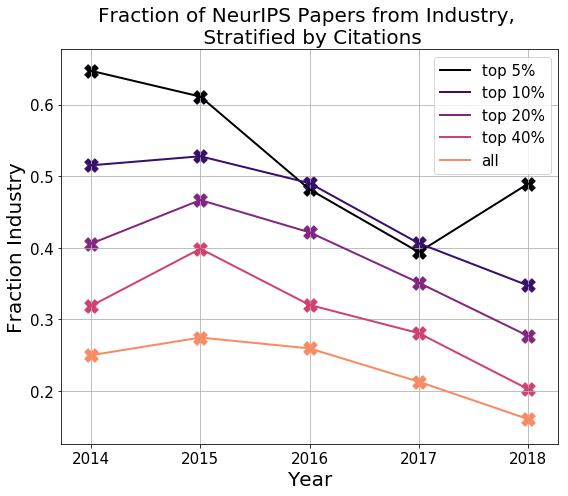

In [11]:
plt.figure(figsize=(8,7))

colors = cm.magma(np.linspace(0,0.75,len(top)))

for i in range(len(top)):
    if i == len(top) - 1:
        plt.plot(neurips_years, n_all[i], label="all", lw=2.0, c=colors[i])
        plt.scatter(neurips_years, n_all[i], marker="X", s=180, c=colors[i])
    else:
        plt.plot(neurips_years, n_all[i], label="top %d%%"%(top[i]*100), 
         lw=2.0, c=colors[i])
        plt.scatter(neurips_years, n_all[i], marker="X", s=180, c=colors[i])

plt.legend(loc="best", fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Fraction Industry', fontsize=20)
plt.title("Fraction of NeurIPS Papers from Industry, \n Stratified by Citations", fontsize=20)
plt.tight_layout()
plt.savefig("NeurIPS_academia_industry.png")

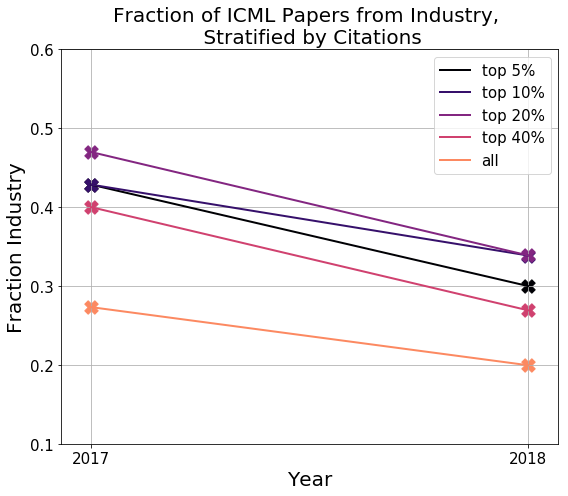

In [12]:
plt.figure(figsize=(8,7))

colors = cm.magma(np.linspace(0,0.75,len(top)))

for i in range(len(top)):
    if i == len(top) - 1:
        plt.plot(icml_years, i_all[i], label="all", lw=2.0, c=colors[i])
        plt.scatter(icml_years, i_all[i], marker="X", s=180, c=colors[i])
    else:
        plt.plot(icml_years, i_all[i], label="top %d%%"%(top[i]*100), 
         lw=2.0, c=colors[i])
        plt.scatter(icml_years, i_all[i], marker="X", s=180, c=colors[i])

plt.legend(loc="best", fontsize=15)
plt.grid()
plt.xticks([2017, 2018], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Fraction Industry', fontsize=20)
plt.title("Fraction of ICML Papers from Industry, \n Stratified by Citations", fontsize=20)
plt.ylim((0.1, 0.6))
plt.tight_layout()
plt.savefig("ICML_academia_industry.png")

There are some noticeable trends: firstly, the number of industry papers seems to be going down from 2016 to 2018. Secondly, there seems to be a high proportion of highly cited papers from industry, particularly in earlier years, such as 2014.

One alternate hypothesis is that many of the authors of these early papers have moved from academia to industry. Let's take a closer look. We'll first look at NeurIPS 2014.

In [13]:
# Top cited papers from NeurIPS 2014
neurips[0].sort_values("citations", ascending=False).head(n=10)

,name,authors,citations,affiliations
164,Generative Adversarial Nets,"[Ian Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farle...",7990,"Senior Staff Research Scientist, Google Brain"
107,Sequence to Sequence Learning with Neural Networks,"[Ilya Sutskever, Oriol Vinyals, Quoc V Le]",6098,Chief Scientist of OpenAI
131,Two-Stream Convolutional Networks for Action Recognition in Videos,"[Karen Simonyan, Andrew Zisserman]",2397,Google DeepMind
244,How transferable are features in deep neural networks?,"[Jason Yosinski, Jeff Clune, Yoshua Bengio, Hod Lipson]",2302,Uber AI Labs; Recursion Pharmaceuticals
118,Learning Deep Features for Scene Recognition using Places Database,"[Bolei Zhou, Agata Lapedriza, Jianxiong Xiao, Antonio Torralba, Aude Oliva]",1724,Assistant Professor at The Chinese University of Hong Kong
316,Recurrent Models of Visual Attention,"[Volodymyr Mnih, Nicolas Heess, Alex Graves, koray kavukcuoglu]",996,DeepMind
126,Semi-supervised Learning with Deep Generative Models,"[Diederik P Kingma, Shakir Mohamed, Danilo Jimenez Rezende, Max Welling]",865,"Research Scientist, Google Brain"
302,Neural Word Embedding as Implicit Matrix Factorization,"[Omer Levy, Yoav Goldberg]",854,Facebook Artificial Intelligence Research
335,Depth Map Prediction from a Single Image using a Multi-Scale Deep Network,"[David Eigen, Christian Puhrsch, Rob Fergus]",848,
381,Joint Training of a Convolutional Network and a Graphical Model for Human Po...,"[Jonathan J Tompson, Arjun Jain, Yann LeCun, Christoph Bregler]",700,IIT Bombay


We see that the majority of the top 10 cited papers have industry affiliations. However, manually looking up the these papers shows a clear difference between affiliations in 2014 and affiliations in 2019:
1. Generative Adversarial Nets has a MILA affiliation
2. Two-Stream CNNs has a University of Oxford affiliation
3. How transferable are features in DNNs has a Cornell/MILA affiliation
4. Semi-supervised Learning with Deep Generative Models has a (primary) University of Amsterdam affiliation
5. Neural Word Embeddings has a Bar-Ilan University affiliation
6. Depth Map Prediction has a NYU affiliation

So the papers were predominantly from academia, but most authors now have an industry affiliation.

What about more recently?

In [16]:
# Top cited papers from NeurIPS 2018
neurips[4].sort_values("citations", ascending=False).head(n=10)

,name,authors,citations,affiliations
22,Are GANs Created Equal? A Large-Scale Study,"[Mario Lucic, Karol Kurach, Marcin Michalski, Sylvain Gelly, Olivier Bousquet]",123,"Research Scientist, Google Brain"
128,Visualizing the Loss Landscape of Neural Nets,"[Hao Li, Zheng Xu, Gavin Taylor, Christoph Studer, Tom Goldstein]",89,US Naval Academy
555,Natasha 2: Faster Non-Convex Optimization Than SGD,[Zeyuan Allen-Zhu],72,Microsoft Research AI / Microsoft Research Redmond
10,Glow: Generative Flow with Invertible 1x1 Convolutions,"[Durk Kingma, Prafulla Dhariwal]",67,"Researcher, OpenAI"
41,PointCNN: Convolution On X-Transformed Points,"[Yangyan Li, Rui Bu, Mingchao Sun, Wei Wu, Xinhan Di, Baoquan Chen]",59,Alibaba AI Labs
616,Simple random search of static linear policies is competitive for reinforcem...,"[Horia Mania, Aurelia Guy, Benjamin Recht]",56,"Associate Professor of EECS, University of California, Berkeley"
563,Isolating Sources of Disentanglement in Variational Autoencoders,"[Tian Qi Chen, Xuechen Li, Roger Grosse, David Duvenaud]",51,"Assistant Professor, University of Toronto"
177,How Does Batch Normalization Help Optimization?,"[Shibani Santurkar, Dimitris Tsipras, Andrew Ilyas, Aleksander Madry]",51,Massachusetts Institute of Technology
198,Adversarially Robust Generalization Requires More Data,"[Ludwig Schmidt, Shibani Santurkar, Dimitris Tsipras, Kunal Talwar, Aleksand...",46,"PhD Candidate, Massachusetts Institute of Technology"
622,Improving Exploration in Evolution Strategies for Deep Reinforcement Learnin...,"[Edoardo Conti, Vashisht Madhavan, Felipe Petroski Such, Joel Lehman, Kennet...",45,"Facebook, MIT"


In my quick skim through, it looked like all affilations -- at least regarding academia or industry -- were mostly correct (though the Visualizing the Loss Landscape affiliation did not belong to the first author.) 

So the 50-50 split we see is reflective of the actual affiliation split.

**Conclusions from Academia/Industry Breakdown**

Because of the noise in the data, it is probably best to ignore the academia/industry breakdown prior to 2017, and base our conclusions on data from 2017 onwards. One thing that remains true is that industry does have a significant number of highly cited papers (around 40% in 5%-10% top cited) compared to the total number of industry papers (around 20%).